<a href="https://colab.research.google.com/github/MrtGrd/LEO-satellite-MU-Massive-MIMO/blob/main/RLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-9-165eaf09260a>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot([float(X[t].T @ rls.W) for t in range(num_samples)], label="Beamformed Output", color="orange")
<ipython-input-9-165eaf09260a>:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_signal = [desired_signal[t] - float(X[t].T @ rls.W) for t in range(num_samples)]


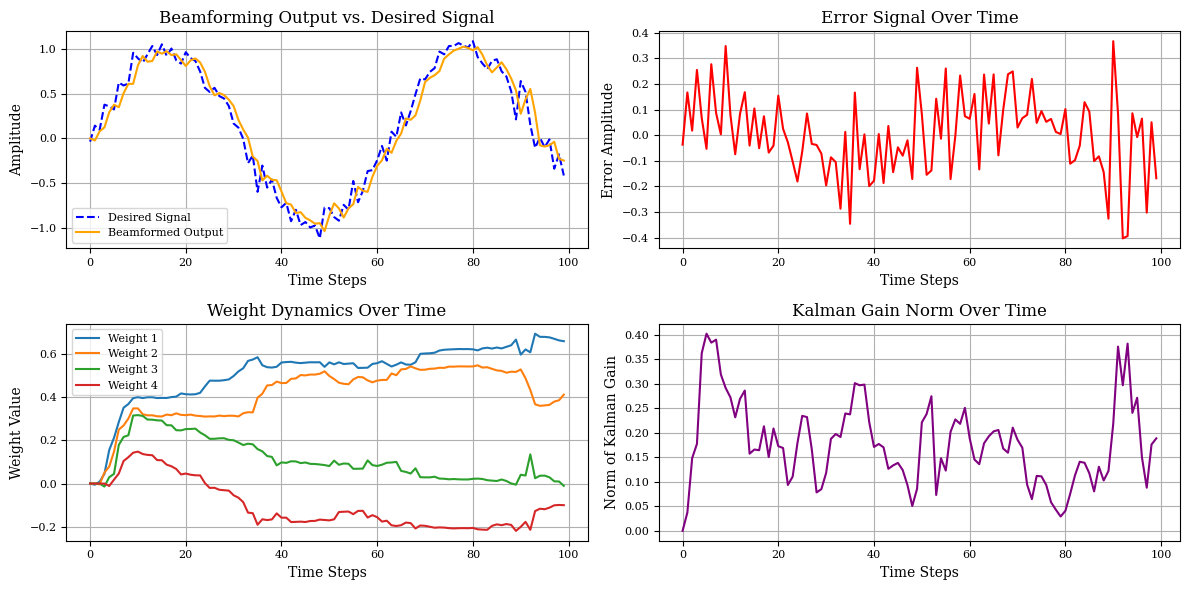

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 10  # Base font size
mpl.rcParams['axes.titlesize'] = 12  # Title font size
mpl.rcParams['axes.labelsize'] = 10  # Axis label font size
mpl.rcParams['xtick.labelsize'] = 8  # X-axis tick label size
mpl.rcParams['ytick.labelsize'] = 8  # Y-axis tick label size
mpl.rcParams['legend.fontsize'] = 8  # Legend font size

# RLS Beamforming Class
class RLSBeamforming:
    def __init__(self, num_taps, lambda_reg=0.99):
        self.num_taps = num_taps
        self.lambda_reg = lambda_reg
        self.W = np.zeros((num_taps, 1))
        self.P = np.eye(num_taps)
        self.K_history = []
        self.W_history = []
        self.Y_history = []

    def update(self, X, y):
        K = self.P @ X / (self.lambda_reg + X.T @ self.P @ X)
        error = y - (X.T @ self.W)
        self.W = self.W + K * error
        self.P = (self.P - K @ X.T @ self.P) / self.lambda_reg
        self.K_history.append(K)
        self.W_history.append(self.W.copy())

    def get_weights(self):
        return np.array(self.W_history)

# Parameters
num_taps = 4
num_samples = 100

# Desired signal (trajectory)
time_steps = np.arange(num_samples)
desired_signal = np.sin(0.1 * time_steps) + 0.1 * np.random.randn(num_samples)

# Generate correlated input signal (X)
X = np.array([
    np.pad(
        desired_signal[max(0, t - num_taps):t][::-1],
        (0, max(0, num_taps - t)),
        mode="constant"
    )
    for t in range(num_samples)
])
X = X.reshape(num_samples, num_taps, 1)

# Initialize RLS and simulate
rls = RLSBeamforming(num_taps=num_taps)
for t in range(num_samples):
    rls.update(X[t], desired_signal[t])

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(desired_signal, label="Desired Signal", linestyle="--", color="blue")
plt.plot([float(X[t].T @ rls.W) for t in range(num_samples)], label="Beamformed Output", color="orange")
plt.title("Beamforming Output vs. Desired Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
error_signal = [desired_signal[t] - float(X[t].T @ rls.W) for t in range(num_samples)]
plt.plot(error_signal, color="red")
plt.title("Error Signal Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Error Amplitude")
plt.grid()

plt.subplot(2, 2, 3)
weights = np.array(rls.W_history)
for i in range(weights.shape[1]):
    plt.plot(weights[:, i], label=f"Weight {i+1}")
plt.title("Weight Dynamics Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Weight Value")
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
kalman_gain_norm = [np.linalg.norm(K) for K in rls.K_history]
plt.plot(kalman_gain_norm, color="purple")
plt.title("Kalman Gain Norm Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Norm of Kalman Gain")
plt.grid()

plt.tight_layout()
plt.show()
